In [1]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM, LlamaForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

from datasets import load_dataset

import functools
import gc
from collections import defaultdict
from typing import List

import torch
import torch.nn as nn
# from tinychat.models import LlavaLlamaForCausalLM
from transformers.models.bloom.modeling_bloom import BloomForCausalLM
from transformers.models.llama.modeling_llama import LlamaForCausalLM
from transformers.models.opt.modeling_opt import OPTForCausalLM

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        # layers = [model.model.layers, model.model.vision_tower.vision_tower.vision_model.encoder.layers]
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    else:
        raise NotImplementedError(type(model))
    return layers

def get_calib_dataset(data="pileval", tokenizer=None, n_samples=512, block_size=512):
    if data == "pileval":
        # dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
        dataset = load_dataset("NeelNanda/pile-10k", split="train")        
    else:
        raise NotImplementedError
    dataset = dataset.shuffle(seed=42)
    samples = []
    n_run = 0
    for data in dataset:
        line = data["text"]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
        if len(line_encoded) > 512:
            continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break
    # now concatenate all samples and split according to block size
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    return [
        cat_samples[:, i * block_size : (i + 1) * block_size] for i in range(n_split)
    ]
    
def move_embed(model, device):
    if isinstance(model, LlamaForCausalLM):
        model.model.embed_tokens = model.model.embed_tokens.to(device)
        ## add the following line to move rotary_emb to GPU as well
        model.model.rotary_emb = model.model.rotary_emb.to(device)
    # elif isinstance(model, LlavaLlamaForCausalLM):
    #     model.model.embed_tokens = model.model.embed_tokens.to(device)
    #     model.model.vision_tower.vision_tower.vision_model.embeddings.to(device)
    elif isinstance(model, OPTForCausalLM):
        model.model.decoder.embed_tokens = model.model.decoder.embed_tokens.to(device)
        model.model.decoder.embed_positions = model.model.decoder.embed_positions.to(device)
    elif isinstance(model, BloomForCausalLM):
        model.transformer.word_embeddings = model.transformer.word_embeddings.to(device)
        model.transformer.word_embeddings_layernorm = model.transformer.word_embeddings_layernorm.to(device)
    elif "mpt" in str(model.__class__).lower():
        model.transformer.wte = model.transformer.wte.to(device)
        model.transformer.emb_drop = model.transformer.emb_drop.to(device)
    elif "falcon" in str(model.__class__).lower():
        model.transformer.word_embeddings = model.transformer.word_embeddings.to(device)
    elif "bigcode" in str(model.__class__).lower():
        model.transformer.wte = model.transformer.wte.to(device)
        model.transformer.wpe = model.transformer.wpe.to(device)
        model.transformer.drop = model.transformer.drop.to(device)
    elif "neox" in str(model.__class__).lower():
        model.gpt_neox.embed_in = model.gpt_neox.embed_in.to(device)
        model.gpt_neox.emb_dropout = model.gpt_neox.emb_dropout.to(device)
        model.embed_out = model.embed_out.to(device)
    else:
        raise NotImplementedError(type(model))
    
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H


# def regularize_H(H, n, sigma_reg):
#     diagmean = torch.diag(H).mean()
#     H /= diagmean
#     idx = torch.arange(len(H))
#     H[idx, idx] += sigma_reg
#     return H * diagmean

# Plot Weight, Hess, W * H

In [ ]:

model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama/Llama-2-7b-hf',
    'meta-llama/Llama-2-31b-hf',
    # 'lmsys/vicuna-7b-v1.5',
    # 'lmsys/vicuna-31b-v1.5',
    # 'facebook/opt-6.7b',
]

n_samples=128
seqlen=512
calib_data="pileval"
batch_size = 12

device = "cuda:2" if torch.cuda.is_available() else "cpu"

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)

    model_path = f"./hf_model/{model_name}"
    output_folder=f'./weight_hess_plot/{model_name}'
    hess_path = f'./hessian/{model_name}'
    os.makedirs(output_folder, exist_ok=True)
    
    hess  = torch.load(hess_path + f'/{calib_data}_n_samples{n_samples}_seqlen{seqlen}.pt')
    hess_eigen = torch.load(hess_path + f'/{calib_data}_n_samples{n_samples}_seqlen{seqlen}_eigen.pt')
    
    
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True) 
    layers = get_blocks(model)  
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            
            ## weight
            z = torch.abs(m.weight.data).cpu().numpy()  # GPU 텐서를 CPU로 변환
            x = np.arange(z.shape[1])  # 열 인덱스
            y = np.arange(z.shape[0])  # 행 인덱스
            x, y = np.meshgrid(x, y)

            fig = plt.figure(figsize=(18, 6))  # 크기를 키워서 가독성 향상
            plt.subplots_adjust(wspace=0.2) 
            ax = fig.add_subplot(131, projection='3d')
            surf = ax.plot_surface(x, y, z, cmap='viridis')
            ax.set_xlabel('Columns')
            ax.set_ylabel('Rows')
            ax.set_zlabel('Abs. Values')
            ax.set_title('W')
            ax.grid(False)
            fig.colorbar(surf, ax=ax, shrink=0.3, aspect=10)
            
            ## hessian
            z =  torch.abs(hess[i][n]).cpu().numpy()  # GPU 텐서를 CPU로 변환
            x = np.arange(z.shape[1])  # 열 인덱스
            y = np.arange(z.shape[0])  # 행 인덱스
            x, y = np.meshgrid(x, y)

            ax = fig.add_subplot(132, projection='3d')
            surf = ax.plot_surface(x, y, z, cmap='viridis')
            ax.set_xlabel('Columns')
            ax.set_ylabel('Rows')
            ax.set_zlabel('Abs. Values')
            ax.set_title('Hessian')
            ax.grid(False)
            fig.colorbar(surf, ax=ax, shrink=0.3, aspect=10)
            
            ## w * sqrt(hessian)
            q = hess_eigen[i][n]['eigenvectors'].to(device)
            s = hess_eigen[i][n]['eigenvalues'].to(device)
            # z = q @ torch.diag(s) @ q.T
            
            Q_D = q @ torch.diag(torch.sqrt(torch.clamp(s, min=0)))
            z = m.weight.data.to(device) @ Q_D
            
            z = torch.abs(z).cpu().numpy()
            x = np.arange(z.shape[1])  # 열 인덱스
            y = np.arange(z.shape[0])  # 행 인덱스
            x, y = np.meshgrid(x, y)

            ax = fig.add_subplot(133, projection='3d')
            surf = ax.plot_surface(x, y, z, cmap='viridis')
            ax.set_xlabel('Columns')
            ax.set_ylabel('Rows')
            ax.set_zlabel('Abs. Values')
            ax.set_title('w * sqrt(hessian)')
            ax.grid(False)
            fig.colorbar(surf, ax=ax, shrink=0.3, aspect=10)

            filename = f"layer_{i}_{n}.png"
            save_path = os.path.join(output_folder, filename)
            plt.suptitle(filename)        
            plt.savefig(save_path, dpi=300)
            plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기



# Plot quip hess

In [ ]:

model_list = [
    # 'meta-llama/Meta-Llama-3-8B',
    'meta-llama/Llama-2-7b-hf',
    'meta-llama/Llama-2-13b-hf',
    # 'lmsys/vicuna-7b-v1.5',
    # 'lmsys/vicuna-13b-v1.5',
    # 'facebook/opt-6.7b',
]
quip_hess_list = [
    '/home/jgryu/Weight_compression/quip-sharp/hess/relaxml/Hessians-Llama-2-7b-6144',
    '/home/jgryu/Weight_compression/quip-sharp/hess/relaxml/Hessians-Llama-2-13b-6144'
]

n_samples=128
seqlen=512
calib_data="pileval"
batch_size = 12

device = "cuda:2" if torch.cuda.is_available() else "cpu"

for model_name, quip_hess_path in zip(model_list, quip_hess_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)

    model_path = f"./hf_model/{model_name}"
    output_folder=f'./weight_hess_plot/{model_name}'
    hess_path = f'./hessian/{model_name}'
    
    hess  = torch.load(hess_path + f'/{calib_data}_n_samples{n_samples}_seqlen{seqlen}.pt')
    # hess_eigen = torch.load(hess_path + f'/{calib_data}_n_samples{n_samples}_seqlen{seqlen}_eigen.pt')
    
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True) 
    layers = get_blocks(model)  
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if 'k_proj' in n or 'v_proj' in n: continue
            if 'up' in n: continue
            fig = plt.figure(figsize=(18, 6))  # 크기를 키워서 가독성 향상
            plt.subplots_adjust(wspace=0.2)
            
            ## hessian
            z =  torch.abs(hess[i][n]/n_samples/seqlen).cpu().numpy()  # GPU 텐서를 CPU로 변환
            x = np.arange(z.shape[1])  # 열 인덱스
            y = np.arange(z.shape[0])  # 행 인덱스
            x, y = np.meshgrid(x, y)

            ax = fig.add_subplot(131, projection='3d')
            surf = ax.plot_surface(x, y, z, cmap='viridis')
            ax.set_xlabel('Columns')
            ax.set_ylabel('Rows')
            ax.set_zlabel('Abs. Values')
            ax.set_title('My Hessian')
            ax.grid(False)
            fig.colorbar(surf, ax=ax, shrink=0.3, aspect=10)
            
            ## quip hessian
            quip_hess = {}
            quip_hess['qkv'] = f'{quip_hess_path}/{i}_qkv.pt'
            quip_hess['o'] = f'{quip_hess_path}/{i}_o.pt'
            quip_hess['up'] = f'{quip_hess_path}/{i}_up.pt'
            quip_hess['down'] = f'{quip_hess_path}/{i}_down.pt'
            
            if 'q' in n or 'k' in n or 'v' in n:
                quip_h = torch.load(quip_hess['qkv'])
            elif 'o' in n:
                quip_h = torch.load(quip_hess['o'])
            elif 'up' in n:
                quip_h = torch.load(quip_hess['up'])
            elif 'down' in n:
                quip_h = torch.load(quip_hess['down'])
        
            H = flat_to_sym(quip_h['flatH'], quip_h['n'])
            mu = quip_h['mu']
            H.add_(mu[None, :] * mu[:, None])
   
            z = torch.abs(H).cpu().numpy()
            x = np.arange(z.shape[1])  # 열 인덱스
            y = np.arange(z.shape[0])  # 행 인덱스
            x, y = np.meshgrid(x, y)

            ax = fig.add_subplot(132, projection='3d')
            surf = ax.plot_surface(x, y, z, cmap='viridis')
            ax.set_xlabel('Columns')
            ax.set_ylabel('Rows')
            ax.set_zlabel('Abs. Values')
            ax.set_title('Quip Hessian')
            ax.grid(False)
            fig.colorbar(surf, ax=ax, shrink=0.3, aspect=10)
            
            H = regularize_H(H, quip_h['n'], 1e-2)
            z = torch.abs(H).cpu().numpy()
            x = np.arange(z.shape[1])  # 열 인덱스
            y = np.arange(z.shape[0])  # 행 인덱스
            x, y = np.meshgrid(x, y)

            ax = fig.add_subplot(133, projection='3d')
            surf = ax.plot_surface(x, y, z, cmap='viridis')
            ax.set_xlabel('Columns')
            ax.set_ylabel('Rows')
            ax.set_zlabel('Abs. Values')
            ax.set_title('Regularized Quip Hessian')
            ax.grid(False)
            fig.colorbar(surf, ax=ax, shrink=0.3, aspect=10)
            
            
            # ax = fig.add_subplot(133)
            # HH = H.flatten().cpu().numpy()
            # ax.hist(np.round(HH, decimals = 10), bins=2000, edgecolor='black', alpha=0.7)
            # ax.set_xlabel('Value')
            # ax.set_ylabel('Frequency')
            # ax.set_yscale('log')
            # ax.set_title('Distribution of Quip Hess Values')
            # ax.grid(False)

            filename = f"reg_quip_layer_{i}_{n}.png"
            save_path = os.path.join(output_folder, filename)
            plt.suptitle(filename)        
            plt.savefig(save_path, dpi=300)
            plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기


In [ ]:
 for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            
            ## hessian
            h = hess[i][n].to(device)
                    
            q = hess_eigen[i][n]['eigenvectors'].to(device)
            s = hess_eigen[i][n]['eigenvalues'].to(device)
            
            Q_D = q @ torch.diag(torch.sqrt(torch.clamp(s, min=0)))
            
            hess_apx1 = q @ torch.diag(s) @ q.T
            hess_apx = Q_D @ Q_D.T

            mse = torch.mean((h - hess_apx)**2).item()
            mse1 = torch.mean((h - hess_apx1)**2).item()
            print(i, n, mse, mse1)


# Diag, Inv diag distribution

In [7]:
import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)


def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)


def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = H.device
    # device = torch.device('cpu')
    (m, n) = H.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        Hr = RHT_H(Hr, SU)
        # Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    # Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

In [ ]:
quip_hess_list = [
    # './quip_hess/Hessians-Llama-2-7b-6144',
    './quip_hess/Hessians-Llama-2-13b-6144'
    # './quip_hess/clip-vit-large-patch14_8192'
]

device = "cuda:4" if torch.cuda.is_available() else "cpu"
for quip_hess_path in quip_hess_list:
    hess_list = os.listdir(quip_hess_path)
    for h in hess_list:
        if not h.endswith('.pt'): continue
        H_dict = torch.load(f'{quip_hess_path}/{h}')
        
        H = flat_to_sym(H_dict['flatH'], H_dict['n'])
        if 'mu' in H_dict:
            mu = H_dict['mu']
            H.add_(mu[None, :] * mu[:, None])
        H = regularize_H(H, H_dict['n'], 1e-4)
        diag = torch.diag(H)
        diag, indices = diag.sort()
        
        # L = torch.linalg.cholesky(H.to('cuda:2'))
        # H_inv = torch.cholesky_inverse(L).cpu()
        # diag_inv = torch.diag(H_inv)
        # diag_inv = diag_inv[indices]
        # diag_inv = torch.tensor(1) / diag_inv
        
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121)
        ax.plot(np.arange(len(diag)), diag)
        # ax.set_ylim(None, 10)
        ax.set_title('diag(H)')
        ax.set_xlabel('Sorted Idx')
        ax = fig.add_subplot(122)
        # ax.plot(np.arange(len(diag_inv)), diag_inv)
        ax.set_title('1/diag(H_inv)')
        ax.set_xlabel('Sorted Idx (diagH)')
        fig.suptitle(h)
        # plt.show()
        
        filename = f"./plot/hess_diag_plot/{quip_hess_path.split('/')[-1]}/{h}.png"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.suptitle(filename)        
        plt.savefig(filename)
        plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기


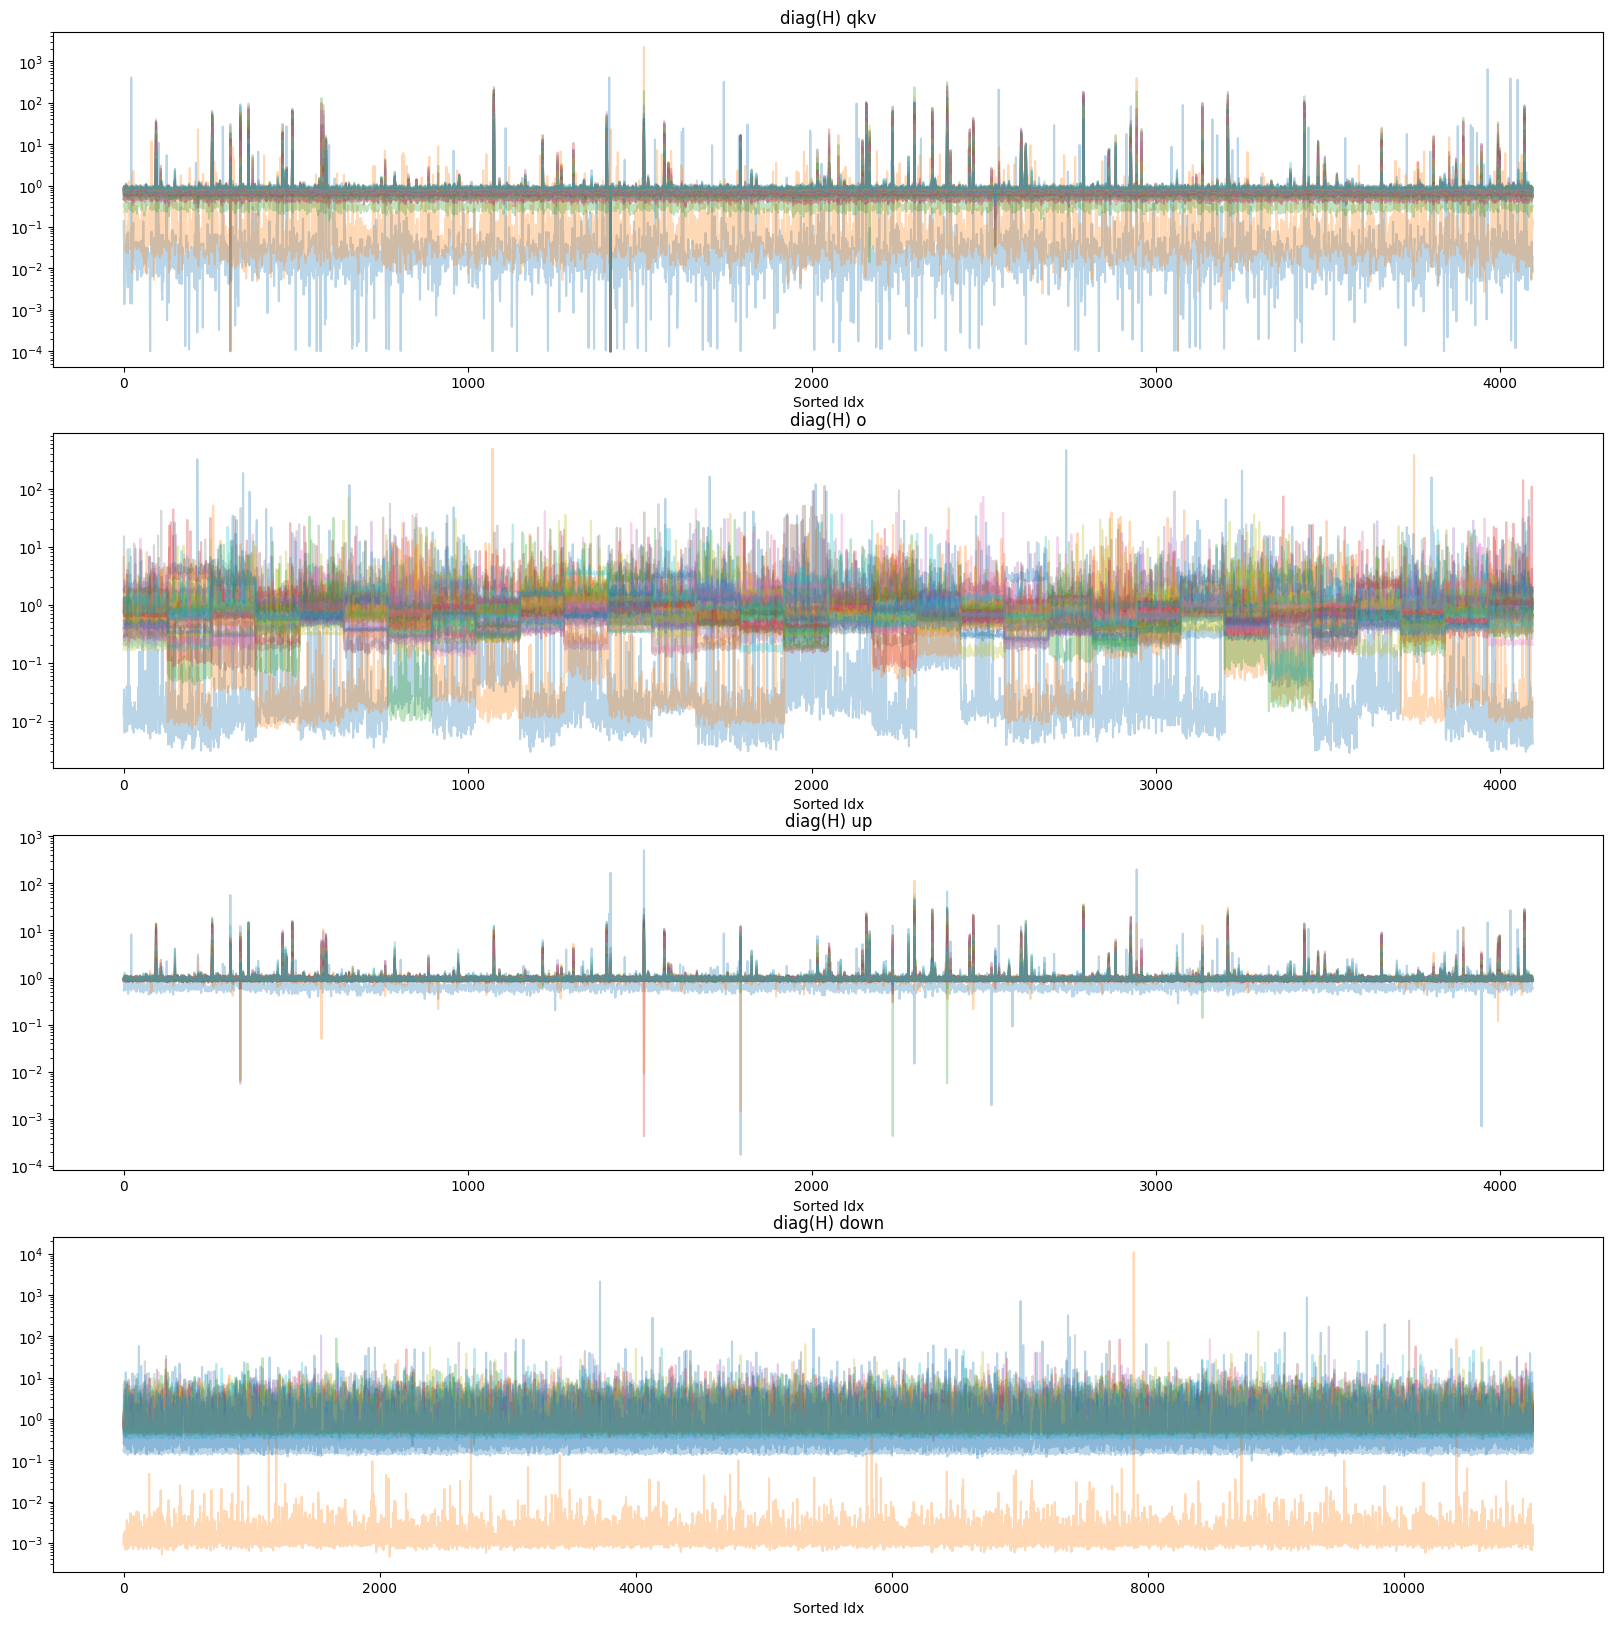

In [4]:
quip_hess_list = [
    './quip_hess/Hessians-Llama-2-7b-6144',
    # './quip_hess/Hessians-Llama-2-13b-6144'
    # './quip_hess/clip-vit-large-patch14_8192'
]


device = "cuda:3"
# device = "cpu"
key = ['qkv', 'o', 'up', 'down']

for quip_hess_path in quip_hess_list:
    fig = plt.figure(figsize=(20, 20))
    
    for i, k in enumerate(key):
        ax = fig.add_subplot(4,1, i+1)
        
        hess_list = os.listdir(quip_hess_path)
        for idx in range(31):            
            H_dict = torch.load(f'{quip_hess_path}/{idx}_{k}.pt')
            
            H = flat_to_sym(H_dict['flatH'], H_dict['n'])
            if 'mu' in H_dict:
                mu = H_dict['mu']
                H.add_(mu[None, :] * mu[:, None])
            H = regularize_H(H, H_dict['n'], 1e-4)
            diag = torch.diag(H)
            # diag, indices = diag.sort()
            
            # L = torch.linalg.cholesky(H.to('cuda:2'))
            # H_inv = torch.cholesky_inverse(L).cpu()
            # diag_inv = torch.diag(H_inv)
            # diag_inv = diag_inv[indices]
            # diag_inv = torch.tensor(1) / diag_inv
            

            ax.plot(np.arange(len(diag)), diag, alpha=0.3)
            # ax.set_ylim(None, 10)
            ax.set_title(f'diag(H) {k}')
            ax.set_xlabel('Sorted Idx')
            ax.set_yscale('log')

        
    # filename = f"./plot/hess_diag_plot/{quip_hess_path.split('/')[-1]}/{h}.png"
    # os.makedirs(os.path.dirname(filename), exist_ok=True)
    # plt.suptitle(filename)        
    plt.show()

### RHT hessian

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1136 is not positive-definite).

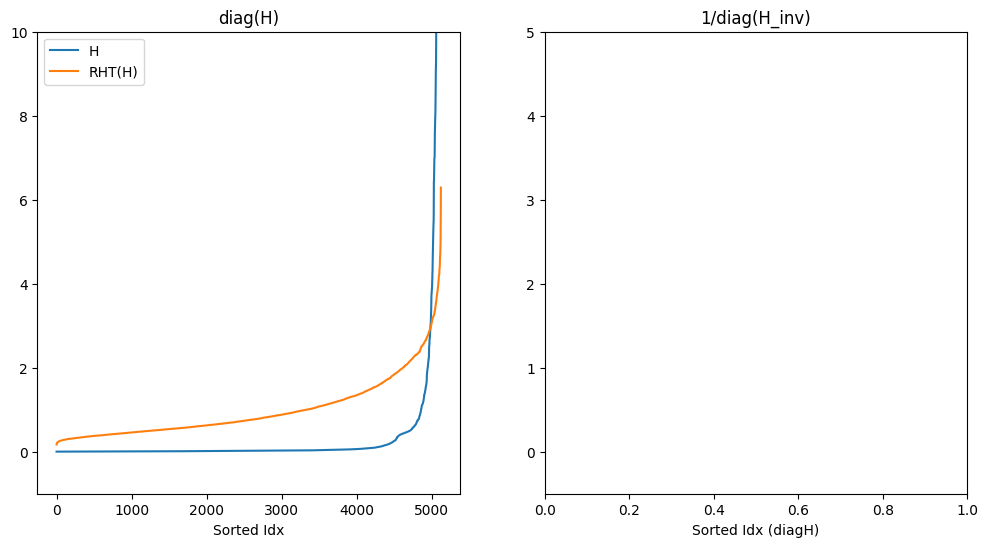

In [7]:
quip_hess_list = [
    './quip_hess/Hessians-Llama-2-7b-6144',
    './quip_hess/Hessians-Llama-2-13b-6144'
]

device = "cuda:2" if torch.cuda.is_available() else "cpu"
for quip_hess_path in quip_hess_list:
    hess_list = os.listdir(quip_hess_path)
    for h in hess_list:
        if not h.endswith('.pt'): continue
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121)
        ax.set_title('diag(H)')
        ax.set_xlabel('Sorted Idx')
        ax.set_ylim(-1, 10)
        
        H_dict = torch.load(f'{quip_hess_path}/{h}')
        
        H = flat_to_sym(H_dict['flatH'], H_dict['n'])
        mu = H_dict['mu']
        H.add_(mu[None, :] * mu[:, None])
        H = regularize_H(H, H_dict['n'], 1e-4)
        
        diag = torch.diag(H)
        diag, indices = diag.sort()
        ax.plot(np.arange(len(diag)), diag, label='H')
        
        Lhr, Hr, w, SU, SV, scaleWH = incoherence_preprocess(H.to('cuda:3'), None, None) 
        
        diag = torch.diag(Hr).cpu()
        diag, indices = diag.sort()
        ax.plot(np.arange(len(diag)), diag, label='RHT(H)')
        ax.legend()
        
        ax = fig.add_subplot(122)
        ax.set_title('1/diag(H_inv)')
        ax.set_xlabel('Sorted Idx (diagH)')
        ax.set_ylim(-0.5, 5)
        L = torch.linalg.cholesky(H.to('cuda:3'))
        H_inv = torch.cholesky_inverse(L).cpu()
        diag_inv = torch.diag(H_inv)
        # diag_inv = diag_inv[indices]
        diag_inv, _ = (torch.tensor(1) / diag_inv).sort()
        ax.plot(np.arange(len(diag_inv)), diag_inv, label='H')
        
        L = torch.linalg.cholesky(Hr.to('cuda:3'))
        H_inv = torch.cholesky_inverse(L).cpu()
        diag_inv = torch.diag(H_inv)
        # diag_inv = diag_inv[indices]
        diag_inv, _ = (torch.tensor(1) / diag_inv).sort()
        ax.plot(np.arange(len(diag_inv)), diag_inv, label='RHT(H)')
        ax.legend()

        fig.suptitle(h)
        
        filename = f"./plot/hess_diag_plot/{quip_hess_path.split('/')[-1]}/RHT/{h}.png"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.suptitle(filename)        
        plt.savefig(filename)
        plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기
